In [15]:
# Cell 1: Imports
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import pandas as pd


In [2]:
train = "veggie_heap_training"
test = "veggie_heap_testing"

h = 128
w = 128
b = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

train_generator = datagen.flow_from_directory(
    train,
    target_size = (h, w),
    batch_size = b,
    class_mode ='categorical',
    subset = 'training'
)

val_generator = datagen.flow_from_directory(
    train,
    target_size=(h, w),
    batch_size=b,
    class_mode='categorical',
    subset='validation'
)

Found 8856 images belonging to 12 classes.
Found 979 images belonging to 12 classes.


In [3]:
model = models.Sequential([
    
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(h, w, 3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    
    layers.Dense(len(train_generator.class_indices), activation='softmax')
    
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0015,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

2025-04-06 21:38:17.191451: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2025-04-06 21:38:17.191473: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-06 21:38:17.191483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pratham-Yoga-Slim-7-14IMH9): /proc/driver/nvidia/version does not exist
2025-04-06 21:38:17.191660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other 

In [4]:
#calling functions to train the model
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=7,
    restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data = val_generator,
    callbacks = [early_stop]
)


Epoch 1/15
277/277 [==============================] - 56s 201ms/step - loss: 1.3675 - accuracy: 0.5430 - val_loss: 0.7644 - val_accuracy: 0.7835
Epoch 2/15
277/277 [==============================] - 56s 203ms/step - loss: 0.4919 - accuracy: 0.8350 - val_loss: 0.4519 - val_accuracy: 0.8580
Epoch 3/15
277/277 [==============================] - 56s 203ms/step - loss: 0.4033 - accuracy: 0.8640 - val_loss: 0.6368 - val_accuracy: 0.7773
Epoch 4/15
277/277 [==============================] - 58s 208ms/step - loss: 0.3406 - accuracy: 0.8870 - val_loss: 0.4036 - val_accuracy: 0.8938
Epoch 5/15
277/277 [==============================] - 60s 218ms/step - loss: 0.2638 - accuracy: 0.9152 - val_loss: 0.3801 - val_accuracy: 0.9019
Epoch 6/15
277/277 [==============================] - 56s 202ms/step - loss: 0.2533 - accuracy: 0.9173 - val_loss: 0.3094 - val_accuracy: 0.9346
Epoch 7/15
277/277 [==============================] - 65s 235ms/step - loss: 0.2309 - accuracy: 0.9229 - val_loss: 0.2801 - val_ac

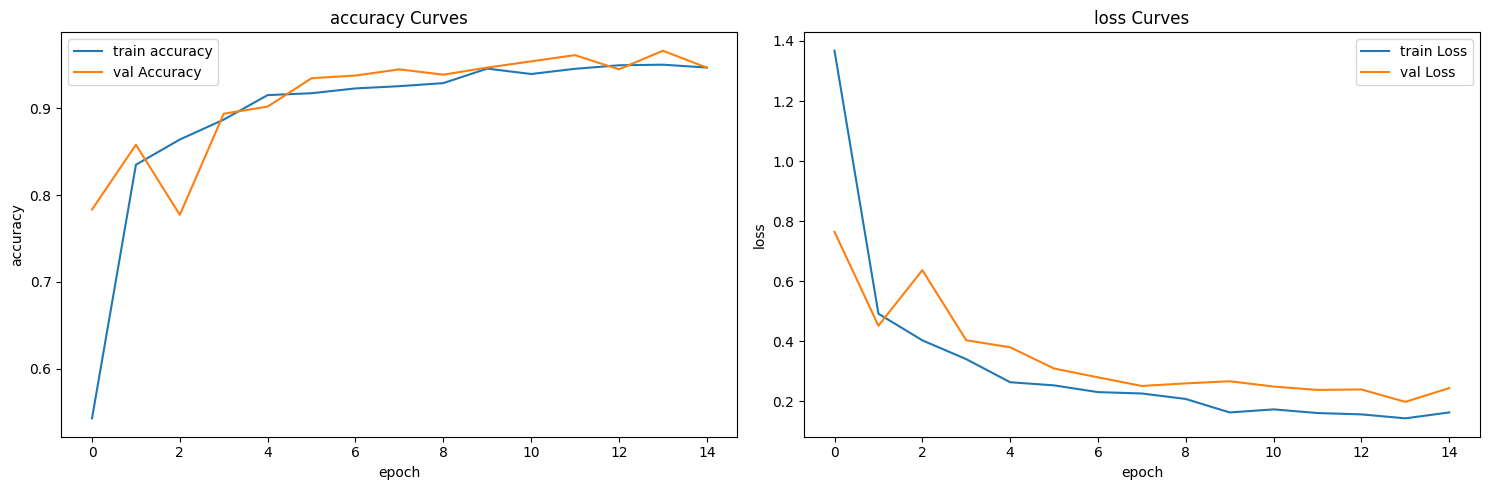

In [5]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy') #plots training and val accuracy v/s epoch
plt.plot(history.history['val_accuracy'], label='val Accuracy')
plt.title('accuracy Curves')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train Loss') #plots training and val loss v/s epoch
plt.plot(history.history['val_loss'], label='val Loss')
plt.title('loss Curves')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

31/31 [==============================] - 2s 74ms/step


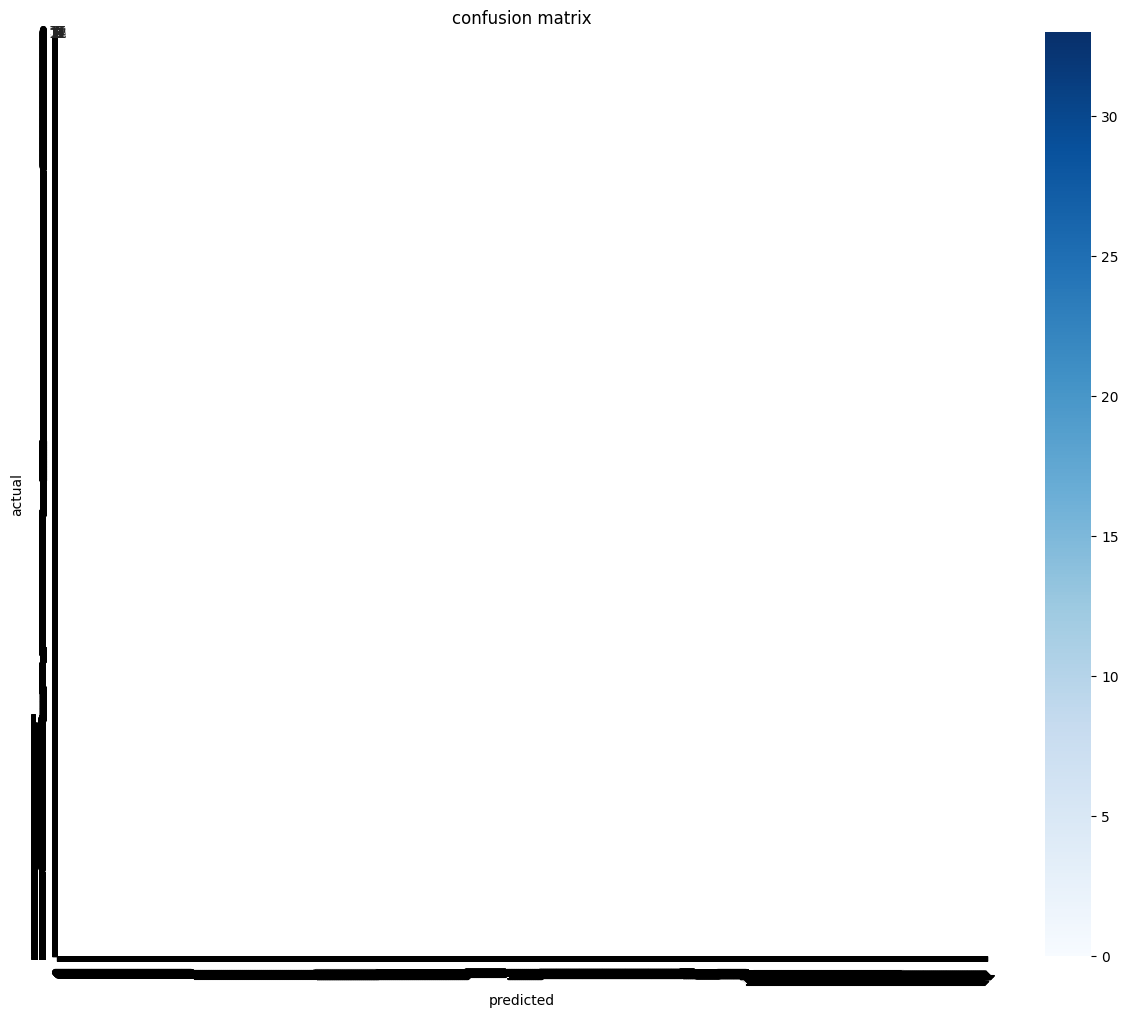

NameError: name 'vals_generator' is not defined

In [7]:
y_true = val_generator.classes
y_pred = model.predict(val_generator) #predicted y values per the model
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', #confusion matrix
            xticklabels= train_generator.classes,
            yticklabels=train_generator.classes)
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [17]:

report = classification_report(y_true, y_pred)

df_report = pd.DataFrame(report).transpose()

df_heatmap = df_report[['precision', 'recall', 'f1-score']].iloc[:-3]

plt.figure(figsize=(10, 8))
sns.heatmap(df_heatmap, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Classification Report (Test Dev Set)')
plt.ylabel('Class')
plt.xlabel('Metrics')
plt.tight_layout()
plt.show()

ValueError: DataFrame constructor not properly called!

In [14]:
num_images = 8

plt.figure(figsize=(15, 15))

images, labels = next(test_generator)
preds = model.predict(images)

for i in range(num_images):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    true_label = [np.argmax(labels[i])]
    pred_label = train_generator.classes[np.argmax(preds[i])]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'test_generator' is not defined

<Figure size 1500x1500 with 0 Axes>